<h1 style="text-align: center;"><b>Heston model for the volatility surface</b></h1>

#### Roland Grinis - MIPT & GrinisRIT
#### Ivan Novikov - MIPT
#### Maksim Sosnin - MIPT
#### Dmitriy Bazanov - MIPT

This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1. $$

We can impose the Feller condition:
$$
2\kappa\theta > \varepsilon ^2
$$
to ensure that the variance $V_t$ stays strictly positive. For real markets, Feller condition is hardly satisfied. For continious time, this is not an issue, because at the moment the variance reaches 0, it will instantly go away from 0. For discretization is requires special consideration for different schemes.

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1}, \\
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

# Delta 
Let's find Delta. See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

# Heston Simulation

$$d \ln X(t) = -\frac{1}{2} V(t) dt + \sqrt{V(t)} d W_X(t),$$

$$d V(t) = \kappa(\theta-V(t)) dt + \varepsilon \sqrt{V(t)} d W_V(t),$$

$$d W_X(t) d W_V(t) = \rho dt.$$

### Euler Discretization Scheme

$$
\begin{aligned}
\ln \hat{X}(t+\Delta) & =\ln \hat{X}(t)-\frac{1}{2} \hat{V}(t) \Delta+\sqrt{\hat{V}(t)} Z_X \sqrt{\Delta}, \\
\hat{V}(t+\Delta) & =V(t)+\kappa(\theta-\hat{V}(t)) \Delta+\varepsilon \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta},
\end{aligned}
$$

where $Z_X$ and $Z_V$ are standardized Gaussian variables with correlation $\rho$. So they can be computed as follows:

$$
\begin{array}{l}
    Z_V = \Phi^{-1}\left(U_1\right), \\
    Z_X = \rho Z_V+\sqrt{1-\rho^2} \Phi^{-1}\left(U_2\right),
\end{array}
$$

where $U_1$ and $U_2$ are independent uniform samples, and $Φ^{−1}$ is the inverse cumulative Gaussian distribution function.

However, the discrete process for $V$ can become negative with non-zero probability, which in turn would make computation of $\sqrt{\hat{V}}$ impossible and cause the time-stepping scheme to fail. The scheme that appears to produce the smallest discretization bias can be written on the form:

$$
\begin{aligned}
\ln \hat{X}(t+\Delta) & =\ln \hat{X}(t)-\frac{1}{2} \hat{V}(t)^{+} \Delta+\sqrt{\hat{V}(t)^{+}} Z_X \sqrt{\Delta} \\
\hat{V}(t+\Delta) & =\hat{V}(t)+\kappa\left(\theta-\hat{V}(t)^{+}\right) \Delta+\varepsilon \sqrt{\hat{V}(t)^{+}} Z_V \sqrt{\Delta},
\end{aligned}
$$
where we use the notation $x^{+}=\max (x, 0)$.

### Bias free Scheme

To obtain a bias-free scheme for sampling the asset price process, first integrate the SDE for $V(t)$, to yield
$$
V(t+\Delta)=V(t)+\int_t^{t+\Delta} \kappa(\theta-V(u)) d u+\varepsilon \int_t^{t+\Delta} \sqrt{V(u)} d W_V(u)
$$
or, equivalently,
$$
\int_t^{t+\Delta} \sqrt{V(u)} d W_V(u)=\varepsilon^{-1}\left(V(t+\Delta)-V(t)-\kappa \theta \Delta+\kappa \int_t^{t+\Delta} V(u) d u\right)
$$
A Cholesky decomposition shows that
$$
d \ln X(t)=-\frac{1}{2} V(t) d t+\rho \sqrt{V(u)} d W_V(u)+\sqrt{1-\rho^2} \sqrt{V(u)} d W(u)
$$
where $W$ is a Brownian motion independent of $W_V$. In integral form,
$$
\begin{aligned}
\ln X(t+\Delta)=\ln X(t)+\frac{\rho}{\varepsilon} & (V(t+\Delta)-V(t)-\kappa \theta \Delta) \\
& +\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right) \int_t^{t+\Delta} V(u) d u+\sqrt{1-\rho^2} \int_t^{t+\Delta} \sqrt{V(u)} d W(u)
\end{aligned}
$$

As $W$ is independent of $V$, conditional on $V(t)$ and $\int_t^{t+\Delta} V(u) d u$, the Ito integral $\int_t^{t+\Delta} \sqrt{V(u)} d W(u)$ is Gaussian with mean zero and variance $\int_t^{t+\Delta} V(u) d u$.

### Process for $V$ (CIR)

Non-central chi-squared distribution:
$$
\mathbb{P}\left(V_{t + \Delta}<V \mid V_{t}\right) \quad = \quad F_{\chi'^{2}}\left(\frac{4 \kappa V}{\varepsilon^{2}\left(1-e^{-\kappa \Delta}\right)} ; \frac{4 \kappa \theta}{\varepsilon^{2}}, \frac{4 V_{t} \kappa e^{-\kappa \Delta}}{\varepsilon^{2}\left(1-e^{-\kappa \Delta}\right)}\right) \quad
$$


$$
\begin{aligned}
m = \mathbb{E}\left( V_{t+\Delta} \mid V_t \right) \quad & = \quad \theta+(\hat{V}(t)-\theta) e^{-\kappa \Delta} \\
s^2 = Var\left( V_{t+\Delta} \mid V_t \right) \quad & = \quad \frac{\hat{V}(t) \varepsilon^2 e^{-\kappa \Delta}}{\kappa}\left(1-e^{-\kappa \Delta}\right)+\frac{\theta \varepsilon^2}{2 \kappa}\left(1-e^{-\kappa \Delta}\right)^2
\end{aligned}
$$


### Quadratic exponential (QE) approximation

Switching rule:
- $ V_t \gg 1: \quad V_{t+\Delta} \approx a \left( b + Z_V \right)^2,\quad \text{where } Z_V \sim \mathcal{N}(0,1).$
- $V_t \ll 1: \quad f_{V_{t+\Delta}}(v) \approx p \delta(v) + \beta(1-\rho) e^{-\beta v}.$

Fast sampling for PDF $f_{V_{t+\Delta}}(v)$:
$$
\begin{aligned}
F_{V_{t+\Delta}}^{-1}(u) & \approx\left\{
    \begin{array}{l}
        0,\ \ 0 \leq u \leq p, \\
        \beta^{-1} \ln \left(\frac{1-p}{1-u}\right),\ \ p \leq u \leq 1,
    \end{array}\right. \\
\end{aligned}
$$
where $u \sim \mathcal{U}[0,1]$ – uniform.

### Generating random numbers

Pseudo-random integers:
$$
0 \leq N_k \leq N, \quad \quad N_{k+1} = f(N_k) \equiv N
$$

$$
u \sim \mathcal{U}[0,1], \quad \quad u_k = \frac{N_k}{N}.
$$

Box-Muller method:
$$ u_1 u_2 \sim \mathcal{U}[0,1] \quad \theta = 2\pi u_2 \quad p = \sqrt{-2 \ln{u_1}} $$

$$ Z_1 = p\cos{\theta} $$
$$ Z_2 = p\sin{\theta} $$
Then $Z_1$ and $Z_2$ are independent random variables with a standard normal distribution $\mathcal{N}(0,1).$


### Computing parameters $(a,\ b,\ p,\ \beta)$

$\psi \equiv \frac{S^{2}}{m^{2}} \quad \text { if } \psi \leqslant 2$:
$$
\begin{array}{l}
b^{2}=2 \psi^{-1}-1+\sqrt{2 \psi^{-1}} \sqrt{2 \psi^{-1}-1} \geq 0 \\
a=\frac{m}{1+b^{2}} \\
\implies \text {2nd moment matches.}
\end{array}
$$

if $\psi \geqslant 1$:
$$
\begin{array}{l}
p=\frac{\psi-1}{\psi+2} \in[0,1) \\
\beta=\frac{1-p}{m}=\frac{2}{m(1+\psi)} \\
\implies \text {moment matching at order 2.}
\end{array}
$$

Switching rule: $\psi_{c} \in [1,2]$, e.g. $\psi = 1.5$.

### Moment matching technique

$$
\begin{array}{l}
Y_{t_{j+1}}^{k}=\hat{V}_{t_{j+1}}^{k}-\hat{V}_{t_{j}}^{k}, \quad \Delta_{j}=t_{j+1}-t_{j}, \quad \hat{V}_{t_{N}}^{k}=\sum_{j=1}^{N} \hat{Y}_{t_{j}}^{k} \\
\Delta=t_{N}-t_{0} ; \quad k=1, \ldots, M \\
\hat{m}_{T}=\frac{1}{M} \sum_{k} \hat{V}_{t_{N}}^{k} \\
\hat{S}_{T}^{2}=\frac{1}{M-1} \sum_{k}\left(\hat{V}_{t_{N}}^{k}-\hat{m}\right)^{2}
\end{array}
$$

$$
\begin{array}{l}
\hat{m}_{T} = M_T \quad \quad m_T = \mathbb{E}[V_T \mid V_{t_0}] \\
\hat{S}^{2}_T = S^{2}_T \quad \quad S^{2}_T = Var[V_T \mid V_{t_0}] \\
\implies V^{k}_T = m_T + \frac{S_T}{\hat{S}_T} (\hat{V}^{k}_T - \hat{m}_T) = \sum_{j=1}^{N} \left(\frac{m_T}{N} + \frac{S_T}{\hat{S}_T} \left(\hat{Y}^{k}_{t_j} - \frac{m_T}{N}\right)\right).
\end{array}
$$


### Simulating $\ln{X_{t+\Delta}}$

Euler Scheme for $\ln{X_{t+\Delta}}$ with QE sampling for $V_{t+\Delta}$ leads to **correlation leaks**.

We use approximation
$$
\begin{array}{l}
 \int_{t}^{t+\Delta} V_{u} d u \approx \Delta \left[\gamma_{1}V_{t} + \gamma_{2}V_{t+\Delta}\right],
\end{array}
$$
where

$$
\begin{array}{l}
    \gamma_{1} + \gamma_{2} = 1 \\
    \gamma_{1}, \gamma_{2} \geq 0,
\end{array}
$$

satisfying the regularity condition:
$$
\mathbb{E}\left(X_{t + \Delta} \mid X_{t}\right)<\infty \Longrightarrow \frac{\rho}{\varepsilon}\left(1+\kappa \gamma_{2} \Delta\right)-\frac{1}{2} \gamma_{2} \Delta \rho^{2}<\frac{2 \kappa}{\varepsilon^{2} (1-e^{-\kappa \Delta})}.
$$

We use discretization scheme
$$
\begin{aligned}
\ln \hat{X}(t+\Delta)= & \ln \hat{X}(t) + \frac{\rho}{\varepsilon} \left( \hat{V}(t+\Delta) - \hat{V}(t)-\kappa \theta \Delta \right)+\Delta\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right)\left(\gamma_1 \hat{V}(t)+\gamma_2 \hat{V}(t+\Delta)\right) \\
& +\sqrt{\Delta} \sqrt{1-\rho^2} \sqrt{\gamma_1 \hat{V}(t)+\gamma_2 \hat{V}(t+\Delta)} \cdot Z \\
= & \ln \hat{X}(t)+K_0+K_1 \hat{V}(t)+K_2 \hat{V}(t+\Delta)+\sqrt{K_3 \hat{V}(t)+K_4 \hat{V}(t+\Delta)} \cdot Z,
\end{aligned}
$$
where $Z$ is a standard Gaussian random variable, independent of $\hat{V}$, and $K_0, \ldots, K_4$ are given by
$$
\begin{aligned}
& K_0=-\frac{\rho \kappa \theta}{\varepsilon} \Delta, \quad K_1=\gamma_1 \Delta\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right)-\frac{\rho}{\varepsilon}, \\
& K_2=\gamma_2 \Delta\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right)+\frac{\rho}{\varepsilon}, \quad K_3=\gamma_1 \Delta\left(1-\rho^2\right), \quad K_4=\gamma_2 \Delta\left(1-\rho^2\right) .
\end{aligned}
$$



### Enforcing Martingale property $\mathbb{E}\left(X_{t+\Delta} \mid X_{t}\right)=X_{t} $
Instead of $K_0$, use

$$
\begin{array}{l}
K_{0}^{*} = \left\{
    \begin{array}{l}
        -\frac{A b^{2} a}{1-2 A a}+\frac{1}{2} \ln (1-2 A a)-\left(K_{1}+\frac{1}{2} \Delta \gamma_1\right), \quad \psi \leq \psi_{c} \\
        -\ln \left(\frac{\beta(1-\rho)}{\beta-A}\right)-\left(K_{1}+\frac{1}{2} \Delta \gamma_{1}\right), \quad \psi > \psi_{c}, \\
    \end{array}\right.
\end{array}
$$

where

$$
A=\frac{\rho}{\varepsilon^{2}}\left(1+\kappa \gamma_{2} \Delta\right)-\frac{1}{2} \gamma_{2} \Delta\rho^{2}.
$$

### Variance reduction: antithetic variates

$$
\begin{array}{l}
u \sim \mathcal{U}(0,1) \longrightarrow 1-u \sim \mathcal{U}(0,1) \longrightarrow \hat{V}=\mathbb{E}\left[P\left(V_{T}\right)\right] \\
Z \sim \mathcal{N}(0,1) \longrightarrow-Z \sim \mathcal{N}(0,1) \longrightarrow V^{-} \\
V_{A V}=\frac{1}{2}\left(\hat{V}+V^{-}\right) \\
\operatorname{Var}\left[V_{A V}\right]=\frac{1}{4} \operatorname{Var}\left[\hat{V}+V^{-}\right]=\frac{1}{4} \operatorname{Var} \hat{V}+\frac{1}{4} \operatorname{Var} V^{-}+\frac{1}{2} \operatorname{Cov}\left(\hat{V}, V^{-}\right) \\
\left|\operatorname{cov}\left(\hat{V}, V^{-}\right)\right| \leqslant \frac{1}{2} \operatorname{Var} \hat{V}+\frac{1}{2} \operatorname{Var} V^{-} \Rightarrow \\
 \Rightarrow \operatorname{Var V}_{A V} \leqslant \operatorname{Var} \hat{V} \text{ - negative correlation effect for antithetics}
\end{array}
$$

### Variance reduction: control variates
$$
\begin{array}{l}
\hat{V} = \mathbb{E}[P(V_T)] \\
\text{C – analytic formula (like a vanilla call)} \\
\hat{C} = \mathbb{E}[P_C(V_T)] \\
V = \hat{V} + \alpha (C - \hat{C}) \\
\end{array}
$$


# Longstaff-Schwarz Method (LSM algorithm)

#### Dynamic programming:
$$
\begin{array}{l}
V_{T_M} = \psi \quad - \quad \text{Payoff} \ \\
C_{T_n} = \mathbb{E}[V_{T_{n+1}}] \quad - \quad \text{(Analytic/numerical integration, trees, PDEs, Monte-Carlo...)}\\
V_{T_n} = max[C_{T_n}, \psi] \\
\end{array}
$$

#### Monte-Carlo + Regression (LSM)

- Simulate N paths $f_{n,k} = f_k(T_n)$, $f_{n,k} \leq K$ – keep contract if ITM;
- Make $g_k = \psi(f_{m,k})$ – cash-flow vector;
- Recursively fit $C_{T_n} = \sum_{l} b_{n,l} \phi_l$ on exercised paths, if $\psi(f_{n,k}) > C_{T_n}(f_{n,k})$ then update $g_k = \psi(f_{n,k})$;
(${\phi_l}$ is basis for $C$, e.g. monomials);
- Calculate $V_0 = \frac{1}{N} \sum_{k} g_k$.

---

# Load C++ code

Implementation is in `src/quant/heston.hh`.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

In [2]:
!mkdir -p build
NOA_LOCATION = '../..'

In [3]:
heston = load(
    name='heston',
    build_directory='./build',
    sources=[f'{NOA_LOCATION}/docs/quant/heston.cc'],
    extra_include_paths=[f'{NOA_LOCATION}/src'],
    extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
    verbose=False
)

In [4]:
n_paths = 10000
n_steps = 2500
dt = 1.0/250
rho = -0.6
S0 = 100.0

xi = 0.009
theta = 0.01
v0 = theta
kappa = 0.06

# xi = 0.1
# theta = 1
# v0 = theta
# kappa = 1

# CIR process simulation

```cpp
/**
 * Generates samples from a noncentral chi-square distribution using approximate
 * Quadratic Exponential scheme from [Andersen2007].
 *
 * @param df Degrees of freedom, must be > 0.
 * @param nonc Non-centrality parameter, must be >= 0.
 * @param size Length of output tensor.
 * @return Tensor with generated samples. Shape: same as `df` and `nonc`, if
 *     they have the same shape.
 */
torch::Tensor
noncentral_chisquare(const torch::Tensor& df, const torch::Tensor& nonc) {
    // algorithm is summarized in [Andersen2007, section 3.2.4]
    double THRESHOLD = 1.5;  // threshold value for switching between sampling algorithms
    torch::Tensor m = df + nonc;
    torch::Tensor s2 = 2*df + 4*nonc;
    torch::Tensor psi = s2 / m.pow(2);
    // quadratic
    torch::Tensor psi_inv = 1 / psi;
    torch::Tensor b2 = 2*psi_inv - 1 + (2*psi_inv).sqrt() * (2*psi_inv - 1).sqrt();
    torch::Tensor a = m / (1 + b2);
    torch::Tensor sample_quad = a * (b2.sqrt() + torch::randn_like(a)).pow(2);
    // exponential
    torch::Tensor p = (psi - 1) / (psi + 1);
    torch::Tensor beta = (1 - p) / m;
    torch::Tensor rand = torch::rand_like(p);
    torch::Tensor sample_exp = torch::where(
            (p < rand) & (rand <= 1),
            beta.pow(-1)*torch::log((1-p)/(1-rand)),
            torch::zeros_like(rand));
    return torch::where(psi <= THRESHOLD, sample_quad, sample_exp);
}

/**
 * Generates paths of Cox-Ingersoll-Ross (CIR) process.
 *
 * CIR process is described by the SDE:
 *
 * dv(t) = κ(θ - v(t)) dt + ξ sqrt(v(t)) dW(t)
 *
 * (see [Grzelak2019, section 8.1.2]).
 *
 * For path generation, Andersen's Quadratic Exponential scheme is used
 * (see [Andersen2007], [Grzelak2019, section 9.3.4]).
 *
 * @param n_paths Number of simulated paths.
 * @param n_steps Number of time steps.
 * @param dt Time step.
 * @param init_state Initial states of the paths, i.e. v(0). Shape: (n_paths,).
 * @param kappa Parameter κ.
 * @param theta Parameter θ.
 * @param xi Parameter ξ.
 * @return Simulated paths of CIR process. Shape: (n_paths, n_steps + 1).
 */
torch::Tensor
generate_cir(int64_t n_paths, int64_t n_steps, double dt,
             const torch::Tensor& init_state,
             double kappa, double theta, double xi)
{
    torch::Tensor paths = torch::empty({n_paths, n_steps + 1},init_state.dtype());
    paths.index_put_({Slice(), 0}, init_state);

    torch::Tensor delta = 4*kappa*theta/(xi*xi) * torch::ones_like(init_state);
    double exp = std::exp(-kappa*dt);
    double c_bar = 1/(4*kappa)*xi*xi * (1 - exp);
    for (int64_t i = 0; i < n_steps; i++) {
        torch::Tensor v_cur = paths.index({Slice(), i});
        torch::Tensor kappa_bar = v_cur * 4*kappa*exp / (xi*xi*(1 - exp));
        // [Grzelak2019, definition 8.1.1]
        torch::Tensor v_next = c_bar * noncentral_chisquare(delta, kappa_bar);
        paths.index_put_({Slice(), i+1}, v_next);
    }
    return paths;
}
```

In [5]:
cir_init_state = v0 * torch.ones(n_paths, dtype=torch.double)
cir_paths = heston.generate_cir(n_paths, n_steps, dt, cir_init_state, kappa, theta, xi)

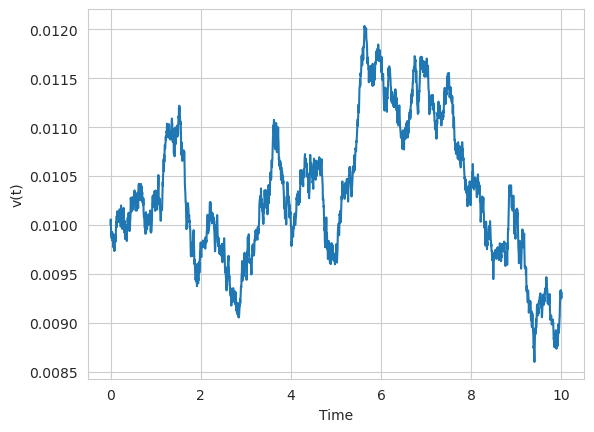

In [6]:
i = 0
plt.plot(torch.linspace(0, n_steps*dt, n_steps+1), cir_paths[i])
plt.ylabel('v(t)')
plt.xlabel('Time')
plt.show()

# Heston simulation

```cpp
/**
 * Generates time series following Heston model:
 *
 * dS(t) = sqrt(v(t))·S(t)·dW_1(t);
 * dv(t) = κ(θ - v(t)) dt + ξ sqrt(v(t)) dW_2(t),
 *
 * using Andersen's Quadratic Exponential scheme [Andersen2007].
 * Also see [Grzelak, section 9.4.3].
 *
 * @param n_paths Number of simulated paths.
 * @param n_steps Number of time steps.
 * @param dt Time step.
 * @param init_state_price Initial states of the price paths, i.e. S(0). Shape: (n_paths).
 * @param init_state_var Initial states of the variance paths, i.e. v(0). Shape: (n_paths).
 * @param kappa Parameter κ.
 * @param theta Parameter θ.
 * @param xi Parameter ξ.
 * @param rho Correlation between underlying Brownian motions for S(t) and v(t).
 * @return Two tensors: simulated paths for price, simulated paths for variance.
 *     Both tensors have shape (n_paths, n_steps + 1).
 */
std::tuple<torch::Tensor, torch::Tensor>
generate_heston(int64_t n_paths, int64_t n_steps, double dt,
                const torch::Tensor& init_state_price,
                const torch::Tensor& init_state_var,
                double kappa, double theta, double xi, double rho)
{
    if (init_state_price.sizes() != torch::IntArrayRef{n_paths})
        throw std::invalid_argument("Shape of `init_state_price` must be (n_paths,)");
    if (init_state_var.sizes() != torch::IntArrayRef{n_paths})
        throw std::invalid_argument("Shape of `init_state_var` must be (n_paths,)");

    double k0 = -rho / xi * kappa * theta * dt;
    double k1 = (rho*kappa/xi - 0.5) * dt - rho/xi;
    double k2 = rho / xi;
    double k3 = (1 - rho*rho) * dt;

    torch::Tensor var = generate_cir(n_paths, n_steps, dt, init_state_var, kappa, theta, xi);
    torch::Tensor log_paths = torch::empty({n_paths, n_steps + 1}, init_state_price.dtype());
    log_paths.index_put_({Slice(), 0}, init_state_price.log());

    for (int64_t i = 0; i < n_steps; i++) {
        torch::Tensor v_i = var.index({Slice(), i});
        torch::Tensor next_vals = log_paths.index({Slice(), i}) + k0 +
                k1*v_i + k2*var.index({Slice(), i+1}) +
                torch::sqrt(k3*v_i) * torch::randn_like(v_i);
        log_paths.index_put_({Slice(), i+1}, next_vals);
    }
    return std::make_tuple(log_paths.exp(), var);
}
```

In [7]:
init_state_price = S0 * torch.ones(n_paths, dtype=torch.double)
init_state_var = v0 * torch.ones(n_paths, dtype=torch.double)
heston_paths, var_paths = heston.generate_heston(
    n_paths, n_steps, dt, init_state_price, init_state_var, kappa, theta, xi, rho)

In [8]:
def plot_heston(i):
    time = torch.linspace(0, n_steps*dt, n_steps+1)
    plt.plot(time, heston_paths[i])
    plt.ylabel('S')
    plt.xlabel('Time')
    plt.show()

    plt.plot(time, var_paths[i])
    plt.ylabel('Variance')
    plt.xlabel('Time')
    plt.show()

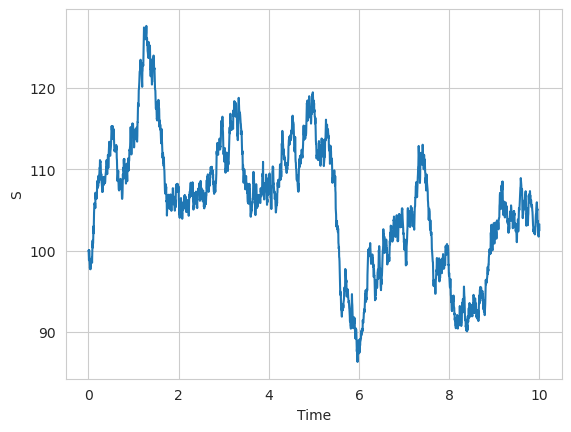

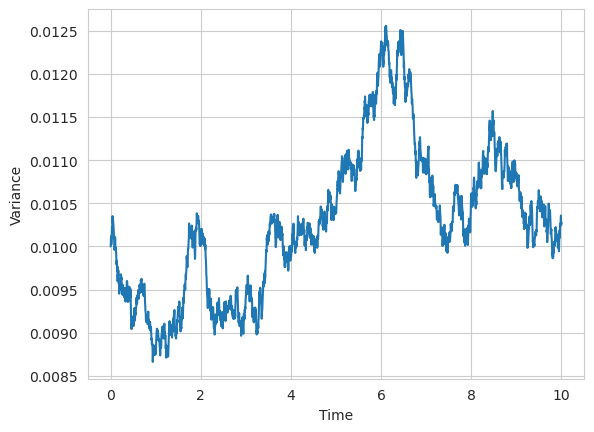

In [9]:
plot_heston(0)

# Monte-Carlo pricing of European Vanilla Option with Heston underlying

In [10]:
# list of strikes from code from supplementary materials to [Cui2017]
karr = [
    0.9371, 0.8603, 0.8112, 0.7760, 0.7470, 0.7216, 0.6699, 0.6137,
    0.9956, 0.9868, 0.9728, 0.9588, 0.9464, 0.9358, 0.9175, 0.9025,
    1.0427, 1.0463, 1.0499, 1.0530, 1.0562, 1.0593, 1.0663, 1.0766,
    1.2287, 1.2399, 1.2485, 1.2659, 1.2646, 1.2715, 1.2859, 1.3046,
    1.3939, 1.4102, 1.4291, 1.4456, 1.4603, 1.4736, 1.5005, 1.5328]
karr = [k*S0 for k in karr]

# list of expiries
tarr = [0.119047619047619, 0.238095238095238, 0.357142857142857,
        0.476190476190476, 0.595238095238095, 0.714285714285714,
        1.07142857142857, 1.42857142857143, 0.119047619047619,
        0.238095238095238, 0.357142857142857, 0.476190476190476,
        0.595238095238095, 0.714285714285714, 1.07142857142857,
        1.42857142857143, 0.119047619047619, 0.238095238095238,
        0.357142857142857, 0.476190476190476, 0.595238095238095,
        0.714285714285714, 1.07142857142857, 1.42857142857143,
        0.119047619047619, 0.238095238095238, 0.357142857142857,
        0.476190476190476, 0.595238095238095, 0.714285714285714,
        1.07142857142857, 1.42857142857143, 0.119047619047619,
        0.238095238095238, 0.357142857142857, 0.476190476190476,
        0.595238095238095,	0.714285714285714, 1.07142857142857,
        1.42857142857143]

assert len(karr) == len(tarr)

In [11]:
def call_payoff(S, K):
    return np.maximum(S - K, 0)

In [12]:
price_arr = []
for i in range(len(karr)):
    expiry_idx = np.argmin(np.abs(np.linspace(0, n_steps*dt, n_steps+1) - tarr[i]))
    price = call_payoff(heston_paths[:, expiry_idx], karr[i]).mean().item()
    price_arr.append(price)

In [13]:
import pandas as pd
print(pd.DataFrame({'K': karr, 'T': tarr, 'Price MC': price_arr}))

         K         T   Price MC
0    93.71  0.119048   6.318749
1    86.03  0.238095  14.024838
2    81.12  0.357143  18.925371
3    77.60  0.476190  22.447525
4    74.70  0.595238  25.257297
5    72.16  0.714286  27.753674
6    66.99  1.071429  32.888102
7    61.37  1.428571  38.408279
8    99.56  0.119048   1.602227
9    98.68  0.238095   2.711695
10   97.28  0.357143   3.987360
11   95.88  0.476190   5.282137
12   94.64  0.595238   6.382507
13   93.58  0.714286   7.387795
14   91.75  1.071429   9.325199
15   90.25  1.428571  10.837954
16  104.27  0.119048   0.191179
17  104.63  0.238095   0.492367
18  104.99  0.357143   0.708233
19  105.30  0.476190   0.923744
20  105.62  0.595238   1.076286
21  105.93  0.714286   1.233898
22  106.63  1.071429   1.667904
23  107.66  1.428571   1.927329
24  122.87  0.119048   0.000000
25  123.99  0.238095   0.000000
26  124.85  0.357143   0.000000
27  126.59  0.476190   0.000189
28  126.46  0.595238   0.001490
29  127.15  0.714286   0.003435
30  128.

# References

* [\[Andersen2007\]](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=946405) Andersen, L.B., 2007. Efficient simulation of the Heston stochastic volatility model. Available at SSRN 946405.
* [Grzelak2019] Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)
* [\[Cui2017\]](https://www.sciencedirect.com/science/article/pii/S0377221717304460) Cui, Y. et al. *Full and fast calibration of the Heston stochastic volatility model.* European Journal of Operational Research 263.2 (2017)
